In [1]:
%matplotlib inline

import os
import os.path as osp
import sys
# import Image
# import sys
import argparse
import os, tempfile, glob, shutil
import random
from datetime import datetime
random.seed(datetime.now())

# import gaussian_process
import GPy
import GPyOpt
import subprocess as sub
import numpy as np
import scipy.spatial
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA

from scipy import optimize
import time

global g_blender_executable_path,  blank_file, render_code, model_file, table_file, temp_dirname, epsilon, \
       filename, time, location_gt, rotation_gt


epsilon = 1e-6


if os.environ.get('BLENDER_PATH') == None:
    print("Please set BLENDER_PATH in bashrc!")
    sys.exit()

g_blender_executable_path = os.environ['BLENDER_PATH']

obj_model_folder = 'obj_models/'
table_model_folder = 'table_models/'

g_blank_blend_file_path = 'blank.blend'
syn_images_folder = 'rendered_images'
if not os.path.exists(syn_images_folder):
    os.mkdir(syn_images_folder)

all_models = []
for file in os.listdir(obj_model_folder):
    if file.endswith(".obj"):
        all_models.append(file)

print(all_models)

# random select model in all_models
# To Do

# model_name and table_name are hard coded
model_name = 'expo_dry_erase_board_eraser'
robot_name = 'reflex'

########################### Input and GT ####################
fps = 24

path = '/home/zhusj/Dropbox/16fall/learningPhysics/data/data/trial4/'

filelist = ['exp1', 'exp2', 'exp3']
timelist = [8,4,1]

location_gt = []
rotation_gt = []

for file in filelist:
    count = 0
    filename = path+file+'.txt'
    with open(filename) as f:

        obj_start_config = []
        hand_start_config = []
        obj_end_config = []
        hand_end_config = []
        for line in f: # read rest of lines
            if count == 7: 
                obj_end_config.append([float(x) for x in line.split()])
            count += 1

    print obj_end_config
    myorder=[0,1,2,6,3,4,5]
    obj_end_config = [ obj_end_config[0][i] for i in myorder]
    print obj_end_config


    obj_end_config = np.array(obj_end_config)
    print obj_end_config.shape

    location_gt.append(obj_end_config[:3])
    rotation_gt.append(obj_end_config[3:])

print location_gt, rotation_gt
##############################################

table_name = 'table'
arm_name ='arm'
image_name = 'demo_img.png'
output_img = osp.join(syn_images_folder, image_name)
output_blend = osp.join(syn_images_folder, image_name+'.blend')

# call blender to render images
blank_file = osp.join(g_blank_blend_file_path)
render_code = osp.join('render_physics_reflex_expo.py')
model_file = osp.join(obj_model_folder, model_name+ '.obj')
robot_file = osp.join(obj_model_folder, robot_name+ '.obj')
table_file = osp.join(table_model_folder, table_name+ '.obj')
# print render_code
# print model_file
temp_dirname = '/home/zhusj/repos/blender_scene_generator/test'  #tempfile.mkdtemp()

/home/zhusj/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


['dasani_water_bottle.obj', 'expo_dry_erase_board_eraser.obj', 'reflex.obj', 'pliers.obj', 'folgers_classic_roast_coffee.obj', 'expo_dry_erase_board_eraser_00000.obj', 'reflex_nc.obj', 'crayola_24_ct.obj', 'robotiq.obj', 'scotch_duct_tape.obj', 'folgers_classic_roast_coffee_00000.obj', 'kleenex_tissue_box.obj']
[[0.543561, -0.123172, 0.54746, -0.00114687, 0.00659373, -0.781483, 0.62389]]
[0.543561, -0.123172, 0.54746, 0.62389, -0.00114687, 0.00659373, -0.781483]
(7,)
[[0.532153, -0.0257914, 0.548445, -0.00623893, -0.00737948, 0.902664, -0.430238]]
[0.532153, -0.0257914, 0.548445, -0.430238, -0.00623893, -0.00737948, 0.902664]
(7,)
[[0.48143, -0.0221645, 0.54965, -0.00235522, -0.00839558, 0.972091, -0.234441]]
[0.48143, -0.0221645, 0.54965, -0.234441, -0.00235522, -0.00839558, 0.972091]
(7,)
[array([ 0.543561, -0.123172,  0.54746 ]), array([ 0.532153 , -0.0257914,  0.548445 ]), array([ 0.48143  , -0.0221645,  0.54965  ])] [array([ 0.62389   , -0.00114687,  0.00659373, -0.781483  ]), arr

In [2]:
def run_physics_engine(filename, mass, friction, force, time):

    location =[]
    rotation = []    

    render_cmd = '%s %s -b --python %s -- %s %s %s %s %s %s %s %s %s' % \
    (g_blender_executable_path, blank_file, render_code, robot_file, model_file, time, \
    filename, force_gt, mass, friction, table_file, temp_dirname)

    p = os.popen(render_cmd,"r")
    while 1:
        line = p.readline()
        if not line: break
        if "location" in line: 
            print "output:", line
            vals = line.split(',')
            count = 0
            for val in vals:
                count += 1
                if count == 1:
                    x= float(val[-6:])
                if count == 2:
                    y= float(val[-7:])

        if "rotation" in line: 
            print "output:", line
            vals = line.split(',')
            count = 0
            for val in vals:
                count += 1
                if count == 1:
                    qw= float(val[-6:])
                if count == 2:
                    qx= float(val[-6:])
                if count == 3:
                    qy= float(val[-6:])
                if count == 4:
                    newstr = val[-10:-3].replace("=", "")
                    qz= float(newstr)
                    
    location.append([x, y])
    location = np.asarray(location)
    rotation.append([qw,qx,qy,qz])
    rotation = np.asarray(rotation)
    return location, rotation

In [7]:
def myf(mass,friction):

#     mass = X[0][0]
#     friction = X[0][1]
    
    y_new = 0
    count = 0
    for file in filelist:        
        filename = path+file+'.txt'
        time = timelist[count]*fps
#         print 'input: ', filename, mass, friction, force_gt, time
        
        location, rotation = run_physics_engine(filename, mass, friction, force_gt, time)  
        dist = np.sqrt(np.sum(((location-location_gt[count][0:2])**2)))
        q_dist = 1 - np.sum(np.multiply(rotation, rotation_gt[count]))**2
        

        print dist, q_dist
        y_new += dist + q_dist
        count += 1

    print "X, y_new",mass,friction,y_new

    return y_new

In [12]:
# RS_result =[]
# RS_time =[]

for count in xrange(1,10):
    random.seed(datetime.now())
    start_time = time.time()
    best_y = 10000
    best_f = 1
    best_m = 1
    result = []
    elapsed_time = 0
    ################## Grid Search #############
    while elapsed_time < 1800:
        m = 0.5*random.random()
        f = 0.7*random.random()

        y = myf(m,f)
        if y < best_y:
            best_y = y
            best_m = m
            best_f = f
            
        result.append([m,f,y,best_m,best_f,best_y])
        elapsed_time = time.time() - start_time
    RS_result.append(result)


output: location:  <Vector (0.5558, -0.1381, 0.7758)>

output: rotation:  <Quaternion (w=0.5380, x=-0.0179, y=-0.0124, z=-0.8427)>

0.0193038417161 0.0114276097907
output: location:  <Vector (0.5532, -0.0417, 0.7749)>

output: rotation:  <Quaternion (w=0.3221, x=0.0007, y=0.0007, z=-0.9467)>

0.0263829445468 0.013670553909
output: location:  <Vector (0.4769, 0.0000, 0.7749)>

output: rotation:  <Quaternion (w=0.3393, x=0.0002, y=-0.0000, z=-0.9407)>

0.0226226868486 0.0119792955253
X, y_new 0.247912879296 0.57467111882 0.105386932337
output: location:  <Vector (0.5620, -0.1438, 0.7747)>

output: rotation:  <Quaternion (w=0.4656, x=0.0016, y=-0.0015, z=-0.8850)>

0.0276678713493 0.0354723330471
output: location:  <Vector (0.5643, -0.0488, 0.7743)>

output: rotation:  <Quaternion (w=0.3916, x=0.0006, y=-0.0005, z=-0.9202)>

0.0395325850781 0.00175913228619
output: location:  <Vector (0.4684, -0.0308, 0.7736)>

output: rotation:  <Quaternion (w=0.2014, x=0.0197, y=-0.0021, z=-0.9793)>

0.

In [20]:
RS_result[9][0]

[0.3819642077197925,
 0.6281400465520359,
 0.13398056725922047,
 0.3819642077197925,
 0.6281400465520359,
 0.13398056725922047]

In [22]:
data = np.empty([10,50])
for i in xrange(0,10):    
    print len(RS_result[i])
    for j in xrange(0,len(RS_result[i])):
        data[i][j] = RS_result[i][j][5]

40
41
41
37
40
35
30
35
39
39


In [25]:
dm = np.mean(data, axis=0)

In [37]:
ds

array([ 0.01252185,  0.01540261,  0.01081926,  0.01008035,  0.00889194,
        0.00889194,  0.00858998,  0.00682424,  0.00702975,  0.00702975,
        0.00620714,  0.00603724,  0.00603724,  0.00651793,  0.00651793,
        0.00601858,  0.00601858,  0.00601858,  0.00601858,  0.00601858,
        0.00601858,  0.00586514,  0.00586514,  0.00579158,  0.00588667,
        0.00588667,  0.00588667,  0.00571668,  0.00929289,  0.00929289,
        0.02771368,  0.02771368,  0.02771368,  0.02771368,  0.02771368,
        0.04125153,  0.04125153,  0.04352762,  0.04352762,  0.04584606,
        0.03544413,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [36]:
dm

array([  1.21044697e-001,   1.12995520e-001,   1.04289091e-001,
         1.02883763e-001,   9.98560511e-002,   9.98560511e-002,
         9.91488265e-002,   9.77979526e-002,   9.69266717e-002,
         9.69266717e-002,   9.55023849e-002,   9.52483551e-002,
         9.52483551e-002,   9.19095928e-002,   9.19095928e-002,
         9.05961160e-002,   9.05961160e-002,   9.05961160e-002,
         9.05961160e-002,   9.05961160e-002,   9.05961160e-002,
         9.03894160e-002,   9.03894160e-002,   8.97696446e-002,
         8.95811360e-002,   8.95811360e-002,   8.95811360e-002,
         8.94056675e-002,   8.70344640e-002,   8.70344640e-002,
         7.83276126e-002,   7.83276126e-002,   7.83276126e-002,
         7.83276126e-002,   7.83276126e-002,   6.14874278e-002,
         6.14874278e-002,   5.21958666e-002,   5.21958666e-002,
         3.73142193e-002,   1.77112446e-002,   1.63393676e-312,
         1.56603289e-312,   1.44720113e-312,   1.56603289e-312,
         1.34322334e-312,   1.60210682e-

In [26]:
ds = np.std(data, axis=0)

In [32]:
dm1 = np.array([1.34905729e-001,   1.34905729e-001,   1.34905729e-001,
         1.34905729e-001,   1.09261989e-001,   1.05832877e-001,
         1.05832877e-001,   1.05832877e-001,   1.05832877e-001,
         9.71199126e-002,   8.09345122e-002,   8.09345122e-002,
         8.09345122e-002,   8.09345122e-002,   8.09345122e-002,
         8.09345122e-002,   8.09345122e-002,   8.09345122e-002,
         8.09345122e-002,   8.09345122e-002,   8.09345122e-002,
         8.09345122e-002,   8.09345122e-002,   8.09345122e-002,
         8.09345122e-002,   8.09345122e-002,   8.09345122e-002,
               8.00915799e-002,   8.00915799e-002,   8.00915799e-002])

In [34]:
ds1 = np.array([0.06363009,  0.01889678,  0.01862063,  0.01455182,  0.01455182,
        0.01455182,  0.01455182,  0.01287687,  0.01140561,  0.03997269,
        0.03873233,  0.04808749,  0.04808749, 0.00146   ,        0.03458641, 
                0.03964225, 0.0143477, 0.02330244,  0.0123582 ,  0.01696089, 
                0.01696089,  0.01366249,       0.00904391,  0.00717711,   0.00632147, 
                0.01129923,  0.03622453,        0.04405995, 1.46321497e-002, 0.01696089,])

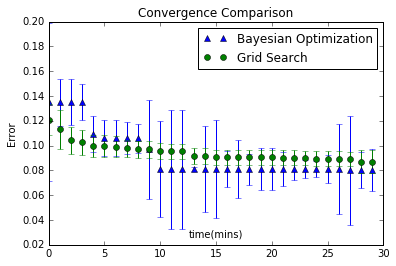

In [42]:
N = 30
ind = np.arange(N)  # the x locations for the groups
pBO = plt.errorbar(ind,dm1[ind],ds1[ind], linestyle='None', marker='^')

pRS= plt.errorbar(ind,dm[ind],ds[ind], linestyle='None', marker='o')
# pGS = plt.plot(GS,'-o')
plt.xlabel("time(mins)", labelpad=-30)
plt.ylabel('Error')
plt.title('Convergence Comparison')

# plt.xlabel('Iterations')
plt.legend((pBO[0],pRS[0]),('Bayesian Optimization', 'Grid Search'))

In [11]:
result

[[0.2644712457683743,
  0.22725096564142927,
  0.11065845042962918,
  0.2644712457683743,
  0.22725096564142927,
  0.11065845042962918],
 [0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.27219927235507907,
  0.37334375286286364,
  0.1362236073867511,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.2682341630860274,
  0.5792451561296736,
  0.12066880566163565,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.4181985405711007,
  0.27894041341252007,
  0.10339373200316601,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.2540308201731392,
  0.40496308448462703,
  0.12025160430945786,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.44305406863482477,
  0.29810554576077697,
  0.12121153226460037,
  0.052106952279988294,
  0.6443155605871688,
  0.095991384215620285],
 [0.12559102741233635,
  0.